# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

# Dataset

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

In [3]:
!pip install datasets

Download the dataset

In [4]:
from datasets import load_dataset
from keras.layers import TextVectorization
import tensorflow as tf
import numpy as np
np.random.seed(42)
ds = load_dataset('generics_kb',trust_remote_code=True)['train']

2024-06-10 06:59:13.734604: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 06:59:13.734729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 06:59:13.852857: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Generating train split:   0%|          | 0/1020868 [00:00<?, ? examples/s]

Filter row with length greater than 8.


In [5]:
ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8 )
corpus = [ '<start> ' + row['generic_sentence'].replace(","," <comma>") + ' <end>' for row in ds ]
corpus = np.array(corpus)


Filter:   0%|          | 0/1020868 [00:00<?, ? examples/s]

Create a tokenizer and Detokenizer

In [7]:
tokenizer=TextVectorization( max_tokens=10000, standardize="lower_and_strip_punctuation", encoding="utf-8",) #con il max prende le piu frequenti. ordina i token del vocab dal piu frequente al meno frequente
tokenizer.adapt(corpus)

class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
          if t == 3:
            s="<start>"
          elif t == 2:
            s="<end>"
          elif t == 7:
            s="<comma>"
          else:
            s=self.index_to_word.get(t, '[UNK]')
          return s

        return ' '.join([ check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
       return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]


detokenizer = TextDetokenizer( tokenizer )
sentences = tokenizer( corpus ).numpy()

Remove from corpus the sentences where any unknow word appears

In [8]:
mask = np.sum( (sentences==1), axis=1) >= 1
original_data = np.delete( sentences, mask , axis=0)

In [9]:
original_data.shape

(241236, 28)

Shuffle the sentences

In [10]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, seed=42):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes])
        #copy of ordered sequences
        result = np.copy(data_batch)
        #shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
          np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])

        return data_batch , result

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

In [12]:
# Make a random permutation of training and test set
np.random.seed(42)
# Shuffle the all data
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

In [13]:
BATCH_SIZE = 64

In [14]:
train_generator = DataGenerator(shuffled_data[:220000], batch_size=BATCH_SIZE)
test_generator = DataGenerator(shuffled_data[220000:], batch_size=BATCH_SIZE)

In [15]:
x, y = test_generator.__getitem__(1)
x = detokenizer(x)
y = detokenizer(y)

for i in range(7):
  print("original: ", y[i])
  print("shuffled: ", x[i])
  print("\n")

original:  <start> digestion is a process that requires quite a bit of energy <end>
shuffled:  <start> process a of energy bit requires is digestion a quite that <end>


original:  <start> some animals acquire their food easily <comma> such as rabbits <comma> horses and elephants <end>
shuffled:  <start> rabbits easily their as elephants and such animals <comma> food <comma> acquire horses some <end>


original:  <start> planning is one of the most important aspects of radiation treatment for breast cancer <end>
shuffled:  <start> of is planning important aspects treatment most radiation for of breast cancer the one <end>


original:  <start> attitudes are often different when age is a variable <end>
shuffled:  <start> a attitudes are age different is variable often when <end>


original:  <start> caffeine is found in tea <comma> coffee <comma> soft drinks and chocolate <end>
shuffled:  <start> found tea is <comma> and soft in <comma> chocolate coffee caffeine drinks <end>


original: 

In [16]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  return (match.size/max(len(p),len(s)))

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, you should NOT consider the start and end tokens.

The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

Let's do an example.

In [ ]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented.
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training.
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

## Methodology
1. **Data Preparation:**
   - Currently, we have pairs of a shuffled sentence and and ordered one.
   - I am going to split the data in triplets:
       - the first element of the triplet is the context - the shuffled sentence
       - the second element is the decoder input - beginning of the ordered sentence with start token at the beginning
       - the third one is the label - the ordered sentence

2. **Model Architecture:**
    - I am going to implement a transformer which is going to predict the probabilities for each sentence element for each token.
    - The idea is that when we pass the shuffled sentence and a part of the original sentence, the model is going to be able to predict the most probable value for the next element in the sentence.

3. **Prediction Procedure:**
    - Initial Step: Start with the shuffled sentence and a start token as the decoder input.
    - Prediction Loop:
        - The model predicts the most probable token on the position of the last non-empty element in the decoder input. In the first iteration, this will be the first element of the sentence.
        - This predicted token will be selected only from the tokens present in the shuffled sentence.
        - Concatenate this token to the decoder input, forming a new decoder input.
        - Repeat this process until all tokens of the ordered sentence are predicted.
    - Token Selection: Each predicted token will be chosen only from the remaining unused tokens in the shuffled sentence.

In [ ]:
import numpy as np
import tensorflow as tf
import keras.backend as k
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
import keras
from keras.callbacks import Callback

## Dataset

We are going to create a new data generator which will return the batches of context, decoder inputs and labels.

In [43]:
def extract_full_data(generator):
    x_list = []
    y_list = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        x_list.append(x_batch)
        y_list.append(y_batch)
    x = np.concatenate(x_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return x, y

def prepare_dataset(X, Y):
    c_set = pad_sequences(np.array([s[1:] for s in X]), maxlen=28, padding='post')
    x_set = Y
    y_set = pad_sequences(np.array([s[1:] for s in Y]), maxlen=28, padding='post')
    context = []
    labels = []
    inputs= []

    for j, x in enumerate(x_set):
        non_null_count = sum(x > 0) - 2
        for i in range(non_null_count):
            context.append(c_set[j])
            inputs.append(pad_sequences([x[:i+1]], maxlen=28, padding='post')[0])
            labels.append(y_set[j])

    return np.array(context), np.array(inputs), np.array(labels)


class TrasnformerDataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, seed=42):
        self.data_generator = DataGenerator(data, batch_size=batch_size)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        x, y = extract_full_data(self.data_generator)
        self.dataset = prepare_dataset(x, y)
        self.indexes = np.arange(len(self.dataset[0]))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataset[0]) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        context = self.dataset[0][indexes].copy()
        inputs = self.dataset[1][indexes].copy()
        labels = self.dataset[2][indexes].copy()
        return (context, inputs), labels

    def on_epoch_end(self):
        self.data_generator.on_epoch_end()
        x, y = extract_full_data(self.data_generator)
        self.dataset = prepare_dataset(x, y)
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

We are extracting x_train, y_train, x_test and y_test only for test purposes. They will not be used in the training.

In [44]:
x_train, y_train = extract_full_data(train_generator)
x_train.shape, y_train.shape

((219968, 28), (219968, 28))

In [45]:
x_test, y_test = extract_full_data(test_generator)
x_test.shape, y_test.shape

((21184, 28), (21184, 28))

We are initializing data generators which will be utilized during training.

In [46]:
transformer_train_generator = TrasnformerDataGenerator(shuffled_data[:200000], batch_size=BATCH_SIZE)
transformer_val_generator = TrasnformerDataGenerator(shuffled_data[200000:220000], batch_size=BATCH_SIZE)

## Model

In [79]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)


class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, embedder, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = embedder
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)
    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)
    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[tf.newaxis, :length, :]
        return x

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, att_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True
        )
        self.last_attn_scores = att_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class SelfAttention(BaseAttention):
    def __init__(self, use_causal_mask=False, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.use_causal_mask = use_causal_mask

    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask=self.use_causal_mask
        )
        x = self.add([x, attn_output])
        return self.layernorm(x)

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

        self.self_attention = SelfAttention(use_causal_mask=False,
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x) 
        return self.ffn(x)


class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,*,d_model,num_heads,dff,dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = SelfAttention(use_causal_mask=True,
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)
        self.last_attn_scores = self.cross_attention.last_attn_scores
        return self.ffn(x)

In [81]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, embedder, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embedder

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x



class Decoder(tf.keras.layers.Layer):
    def __init__(self, embedder, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(embedder, vocab_size=vocab_size, d_model=d_model)

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                         dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        x = self.pos_embedding(x)  # (batch_size, seq_len, d_model)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)
        self.last_attn_scores = self.dec_layers[-1].last_attn_scores
        return x

In [82]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
               vocab_size, dropout_rate=0.1):
        super().__init__()
        self.embedder = tf.keras.layers.Embedding(input_vocab_size, d_model, mask_zero=True)
        self.encoder = Encoder(self.embedder,num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(self.embedder,num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        context, x  = inputs
        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        logits = self.final_layer(x)  # (batch_size, target_len, vocab_size)

        try:
            del logits._keras_mask
        except AttributeError:
            pass
        return logits

## Training

In [83]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_embedding, warmup_steps=5000):
        super().__init__()

        self.d_embedding = d_embedding
        self.d_embedding = tf.cast(self.d_embedding, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_embedding) * tf.math.minimum(arg1, arg2)


In [ ]:
K_VALUE = 0.97

def loss(label, pred):

    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    final_array = tf.pow(K_VALUE,tf.cast(tf.range(1,28+1),tf.float32))

    mask = tf.cast(mask, dtype=loss.dtype)
#     mask*=final_array

    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)


In [87]:
num_layers = 8
d_embedding = 128
d_feed_forward = 512
num_heads = 8
dropout_rate = 0.2
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_embedding,
    num_heads=num_heads,
    dff=d_feed_forward,
    vocab_size=10_000,
    dropout_rate=dropout_rate)
learning_rate = LearningRateScheduler(d_embedding, warmup_steps=10000)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)


transformer.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[accuracy])

transformer.build(input_shape = [(None, 28), (None, 28)])

transformer.summary()

Model: "transformer_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_11 (Encoder)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_9 (Decoder)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_352 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [77]:
transformer.count_params()

19989776

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

We are creating a custom callback which is going to track the validation loss and the validation accuracy during the epoch. This is essential because the model can overfit in less than 3 epochs. So we need to be able to track its performance and act accordingly before that.

In [ ]:
class PrintValLoss(Callback):
    def __init__(self, transformer_val_generator, steps=6000, patience=2):
        super(PrintValLoss, self).__init__()
        self.transformer_val_generator = transformer_val_generator
        self.steps = steps
        self.best_val_loss = float('inf')  
        self.best_accuracy = 0  
        self.wait = 0  # Counter for how many epochs the accuracy hasn't improved
        self.patience = patience  # Number of epochs to wait before early stopping

    def on_batch_end(self, batch, logs=None):
        if batch > 0 and batch % self.steps == 0:
            val_loss, val_accuracy = self.model.evaluate(self.transformer_val_generator, verbose=0)
            print(f'\nBatch {batch}: Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            # Check if current accuracy is better than the best so far
            if val_accuracy > self.best_accuracy:
                print(f'\nAccuracy improved from {self.best_accuracy:.4f} to {val_accuracy:.4f}. Saving weights.')
                self.best_accuracy = val_accuracy
                self.model.save_weights('best.weights.h5')  # Save best weights
                self.wait = 0  # Reset wait counter
            else:
                self.wait += 1
                # If accuracy hasn't improved for patience epochs, stop training
                if self.wait >= self.patience:
                    print(f'\nAccuracy did not improve for {self.patience} epochs. Early stopping.')
                    self.model.stop_training = True

In [ ]:
print_val_loss_callback = PrintValLoss(transformer_val_generator=transformer_val_generator, steps=10000)


epochs = 3

history = transformer.fit(
    transformer_train_generator,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    callbacks=[print_val_loss_callback],
    validation_data = transformer_val_generator
)

Epoch 1/3
    1/38544 ━━━━━━━━━━━━━━━━━━━━ 977:28:26 91s/step - accuracy: 0.0000e+00 - loss: 9.2541

W0000 00:00:1718007344.892374     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10000/38544 ━━━━━━━━━━━━━━━━━━━━ 51:08 107ms/step - accuracy: 0.3073 - loss: 5.2983

W0000 00:00:1718008426.458520     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Batch 10000: Validation Loss: 2.0582, Validation Accuracy: 0.5301

Accuracy improved from 0.0000 to 0.5301. Saving weights.
20000/38544 ━━━━━━━━━━━━━━━━━━━━ 35:15 114ms/step - accuracy: 0.4313 - loss: 3.5728
Batch 20000: Validation Loss: 1.4885, Validation Accuracy: 0.6147

Accuracy improved from 0.5301 to 0.6147. Saving weights.
30000/38544 ━━━━━━━━━━━━━━━━━━━━ 16:33 116ms/step - accuracy: 0.5018 - loss: 2.8222
Batch 30000: Validation Loss: 1.3754, Validation Accuracy: 0.6503

Accuracy improved from 0.6147 to 0.6503. Saving weights.
38544/38544 ━━━━━━━━━━━━━━━━━━━━ 4809s 122ms/step - accuracy: 0.5423 - loss: 2.4564 - val_accuracy: 0.6640 - val_loss: 1.3618
Epoch 2/3
 9250/38544 ━━━━━━━━━━━━━━━━━━━━ 52:08 107ms/step - accuracy: 0.7641 - loss: 0.7937

## Prediction

In [ ]:
def generate_prediction(shuffled, model):
    max_count = sum(shuffled > 3)
    generated = pad_sequences(np.array([shuffled[:1]]), maxlen=28, padding='post')[0]
    available_tokens = shuffled[1:sum((shuffled>0))-1].tolist()
    context = pad_sequences(np.array([shuffled[1:]]), maxlen=28, padding='post')[0]
    for count in range(max_count):
        prediction = model.predict((np.array([context]), np.array([generated])), verbose=0)
        relevant_logits = prediction[0, count, available_tokens]
        generated_index = np.argmax(relevant_logits, axis=-1)
        generated_token = available_tokens[generated_index]
        available_tokens.remove(generated_token)
        generated[count+1] = generated_token

    return generated[1:sum(generated>0)]

## Testing

In [ ]:
def get_average_score(x, y, model, print_allowed=False):
    num_examples = len(x)
    generated_scores = []
    for i in range(num_examples):
        shuffled = x[i][1:sum(x[i]>0)-1]
        ordered = y[i][1:sum(y[i]>0)-1]
        generated_scores.append(score(ordered, generate_prediction(x[i],model)))
        if print_allowed:
            print(f'{i+1}.Generated: {gs[-1]}')

    return generated_scores, sum(generated_scores)/num_examples

In [ ]:
x_test_length = len(x_test)

# Generate 3000 random indices
random_indices = np.random.choice(x_test_length, 500, replace=False)

In [ ]:
gs, average_generated_score = get_average_score(x_test[random_indices], y_test[random_indices], transformer, print_allowed=True)
print(f'Average score on generated data: {average_generated_score}')

In [27]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [128]:
transformer.count_params()

7536256

In [ ]:
transformer.summary()

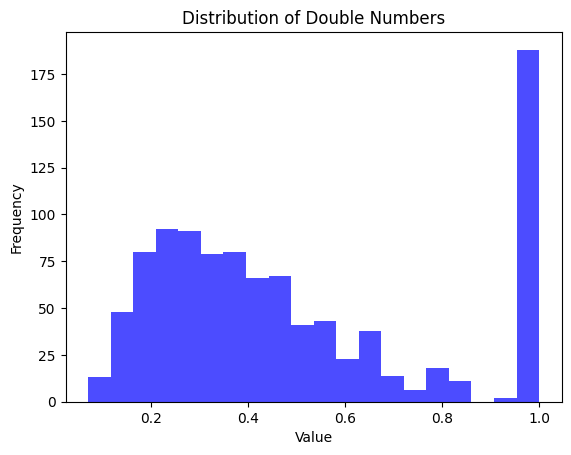

In [92]:
import matplotlib.pyplot as plt
import numpy as np


# Create a histogram
plt.hist(gs, bins=20, alpha=0.7, color='blue')

# Add title and labels
plt.title('Distribution of Double Numbers')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [ ]:
def generate_prediction2(shuffled, model):
    max_count = sum(shuffled > 3)
    generated = pad_sequences(np.array([shuffled[:1]]), maxlen=28, padding='post')[0]
    available_tokens = shuffled[1:sum((shuffled>0))-1].tolist()
    context = pad_sequences(np.array([shuffled[1:]]), maxlen=28, padding='post')[0]
    for count in range(max_count):
        prediction = model.predict((np.array([context]), np.array([generated])), verbose=0)
        relevant_logits = prediction[0, count, available_tokens]
        generated_index = np.argmax(relevant_logits, axis=-1)
        generated_token = generated_index
        generated_token = available_tokens[generated_index]
#         available_tokens.remove(generated_token)
        generated[count+1] = generated_token

    generated[sum(generated>0)] = 2
    return generated[:sum(generated>0)]
def get_average_score2(x, y, model):
    num_examples = len(x)
    rs = []
    gs = []
    for i in range(num_examples):
        shuffled = x[i][:sum(x[i]>0)]
        ordered = y[i][:sum(y[i]>0)]

        rs.append(score(ordered, shuffled))
        gs.append(score(ordered, generate_prediction2(x[i],model)))
        print(f'{i+1}.Random: {rs[-1]}')
        print(f'{i+1}.Generated: {gs[-1]}')

    return gs, sum(rs)/num_examples, sum(gs)/num_examples

In [ ]:
generated_scores, average_random_score, average_generated_score = get_average_score2(x_test[2000:3000], y_test[2000:3000], transformer)
print(f'Average score on shuffled data: {average_random_score}')
print(f'Average score on generated data: {average_generated_score}')